In [ ]:
#Same thing with TESS, just since they have KP (Known Planet) and CP (Confirmed Planet) We're gonna combine those two,
#put False Posititives in with em for training data,
#then split of Candidates so it can give em all predictions
'''
CP=confirmed planet
KP=known planet
FP=false positive
PC=planetary candidate
'''
'''
Room for improvement:         (8/7/23)
-try to increase model accuracy by using different model architechtures **
  e.g. activiation functions(leaky-relu), more/less neurons and layers,
  advanced overfitting layers etc. (such as batch normalization)
-"feature engineering" such as making ratios, or different categories (of stars, etc.). Ask Handron for advice.
-Note somewhere that this is only trained on like 1000 planets, which seems like a lot but is only a grain of sand on the beach
-try to visualize both the data and candidate predictions better, not important now but in the long run will help with ppl out-of-the-loop
'''

# Importing Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.callbacks import EarlyStopping

In [ ]:
path = '/content/TESS_shorter.csv'

df = pd.read_csv(path)

In [ ]:
df.head()

,toi,tfopwg_disp,pl_tranmid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad
0,1000.01,FP,2.459230e+06,2.171348,2.01722,656.886099,5.818163,22601.948581,3127.204052,9.604000,485.735,10249.0,4.19,2.16986
1,1001.01,PC,2.459988e+06,1.931646,3.16600,1286.000000,11.215400,44464.500000,4045.000000,9.423440,295.862,7070.0,4.03,2.01000
2,1002.01,FP,2.459225e+06,1.867557,1.40800,1500.000000,23.752900,2860.610000,2037.000000,9.299501,943.109,8924.0,NaN,5.73000
3,1003.01,FP,2.458493e+06,2.743230,3.16700,383.410000,NaN,1177.360000,1631.000000,9.300300,7728.170,5388.5,4.15,NaN
4,1004.01,FP,2.459987e+06,3.573014,3.37000,755.000000,11.311300,54679.300000,4260.000000,9.135500,356.437,9219.0,4.14,2.15000


In [ ]:
df.shape

(6687, 14)

In [ ]:
df.iloc[0,:]

toi                   1000.01
tfopwg_disp                FP
pl_tranmid     2459229.630046
pl_orbper            2.171348
pl_trandurh           2.01722
pl_trandep         656.886099
pl_rade              5.818163
pl_insol         22601.948581
pl_eqt            3127.204052
st_tmag                 9.604
st_dist               485.735
st_teff               10249.0
st_logg                  4.19
st_rad                2.16986
Name: 0, dtype: object

In [ ]:
df.tfopwg_disp.value_counts()

PC     4407
FP      933
KP      514
APC     393
CP      352
FA       87
Name: tfopwg_disp, dtype: int64

this should look like NASA's exoplanet population graph (like HR graph for exoplanets ig)

# Data Processing

TODO
*   Make the tfopwg_disp into categorical and one-hot-encode
*   "sequence" the data (actually make sure yk what its doing and its the right datatype)
*   Test/Train Split
*   Split a candidates df



In [ ]:
# Not going to deal with NA values right now, so dropping
df= df.dropna()

In [ ]:
# The Documentation said nothing about APC or FA, so I'll be dropping it as I have no clue what it means
df = df.loc[df['tfopwg_disp'].isin(['PC', 'FP','KP','CP'])]

In [ ]:
# Combining KP (Known Planet) and CP (Confirmed Planet) as POS (Positive)
df['tfopwg_disp'] = df['tfopwg_disp'].replace({'KP': 'POS', 'CP': 'POS'})

In [ ]:
# Labels to Categorical
df['tfopwg_disp'] = df['tfopwg_disp'].astype('category')
df['toi_disp'] = df['tfopwg_disp'].cat.codes

In [ ]:
df['toi_disp'].value_counts()

In [ ]:
# Candidate [1]
# Positive [2]
# Negative [0]

# Rows being dropped
drop = ['toi', 'tfopwg_disp', 'toi_disp']

# Candidate Split
Candidates = df[df['toi_disp'] == 1]
# maybe just reset the whole index rn
Candidate_names = Candidates['toi']
Candidate_names = pd.DataFrame(Candidate_names)
Candidate_names = Candidate_names.reset_index(drop=True)
Candidates = Candidates.drop(drop, axis=1)

# X Split
X = df[df['toi_disp'].isin([0,2])]
y = X.iloc[:, -1:]
y = y.replace(2, 1)
X = X.drop(drop, axis=1)

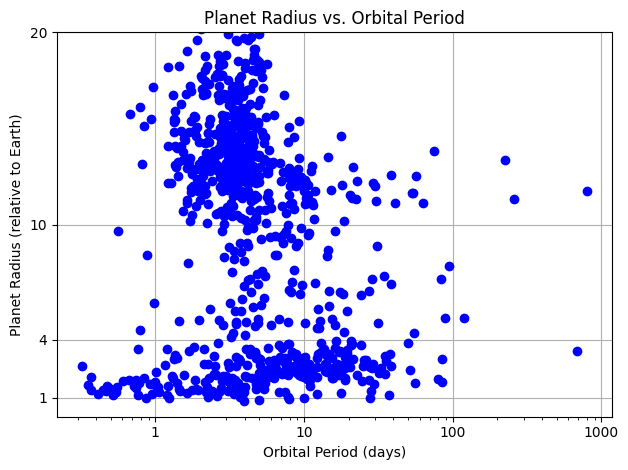

In [ ]:
## TODO
## Make the Planet Radius a log scale like NASA 1-4-10-20-40
## https://www.nasa.gov/image-feature/ames/kepler/exoplanet-populations

new_df = df[df['toi_disp'].isin([2])]

# Orbital periods (in Earth days)
orbital_periods = new_df.pl_orbper

# Planet radii (relative to Earth)
planet_radii = new_df.pl_rade

# Create a figure and axis
fig, ax = plt.subplots()

# Set the x-axis to a log scale
ax.set_xscale('log')

# Plot the data
ax.plot(orbital_periods, planet_radii, 'bo')

# Label the axes and add a title
ax.set_xlabel('Orbital Period (days)')
ax.set_ylabel('Planet Radius (relative to Earth)')
ax.set_title('Planet Radius vs. Orbital Period')

# Customize the x-axis ticks
ticks = [1, 10, 100, 1000]
y_ticks = [1, 4, 10, 20]

ax.set_xticks(ticks)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())


plt.ylim(0, 20)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

In [ ]:
# Scaling Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Candidates = scaler.transform(Candidates)

# Neural Network

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(12,)))
model.add(Dropout(.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(.3))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(.3))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
### HYPERPARAMETERS

# num_epochs
epochs = 200

# batch_size
batch_size = 32

# learning_rate
#learning_rate = 1e-4

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

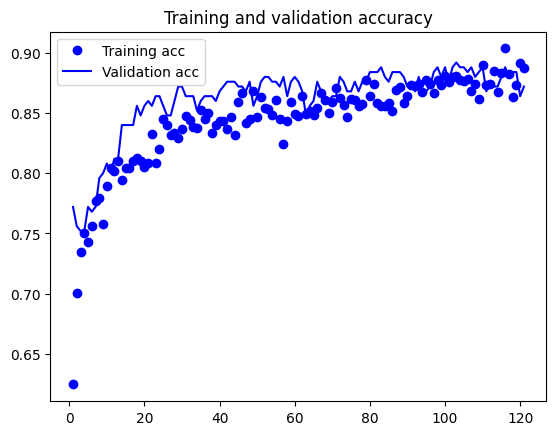

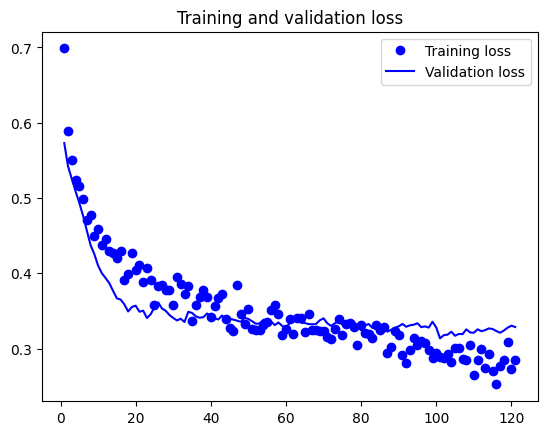

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
model.save('toi_prediction.h5')

# Candidate Prediction

In [ ]:
# Predicting Candidates
model = load_model('toi_prediction.h5')

predictions = model.predict(Candidates)

# Dataframe of Candidate Names and their Prediction
pred_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df = pd.concat([Candidate_names, pred_df], axis=1)

predictions_df

<Axes: >

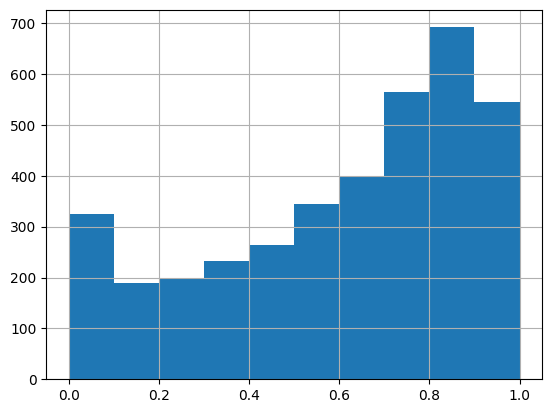

In [ ]:
predictions_df['predictions'].hist()

In [ ]:
# Round predictions to 2 decimal places and multiply by 100 for percent
predictions_df['predictions'] = (predictions_df['predictions'] * 100).apply(lambda x:round(x,2))
predictions_df['predictions'] = (predictions_df['predictions'].astype(str) + '%')

In [ ]:
# the number is the star (in this case 3976) and then .01 if its b, .02 if c, etc.
predictions_df[predictions_df['toi'] == 3976.01]

,toi,predictions
1649,3976.01,63.65%


In [ ]:
temp = [ 3629.01,
            1518.01,
            1516.01,
            1444.01,
            1181.01,
            1442.01,
            2081.01,
            2260.01,
            2018.01,
            2445.01,
            4010.01,
          ]

In [ ]:
# ALL PREDICTIONS FOR TONIGHT
tonight = [ 1181.01,
            1431.01,
            2260.01,
            1288.01,
            5205.01,
            1442.01,
            1516.01,
            2411.01,
            1444.01,
            2046.01,
            3912.01,
            1442.01,
            4010.01,
            1470.01
          ]

tonight_pred = predictions_df[predictions_df['toi'].isin(tonight)]
tonight_pred

,toi,predictions
1609,3912.01,94.4%


In [ ]:
# only KOI-1416 b and KOI-3976 b are Candidates

# Visualizing Candidate Data

In [ ]:
Candidates = Candidates.reset_index(drop=True)

In [ ]:
Candidate_Pred = pd.concat([Candidates, predictions_df], axis=1)

In [ ]:
Candidate_Pred

In [ ]:
# This is all autogenerated by google colab

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.6):
  from matplotlib import pyplot as plt
  figsize = (len(colname_pairs) *5* figscale, 5*figscale)
  plt.figure(figsize=figsize)
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    # Note: `32*figscale` may be too large; scaling by # of datapoints may be
    # wiser.
    ax.scatter(df[x_colname], df[y_colname], s=(32 * figscale), alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(Candidate_Pred, *[[['st_tmag', 'predictions'], ['st_dist', 'predictions'], ['st_rad', 'st_logg'], ['st_logg', 'st_rad']]], **{})
chart

# Correlation Matrix

In [ ]:
import seaborn as sns

<ipython-input-80-4715ce01cdb6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Text(0.5, 1.0, 'Correlation Heatmap')

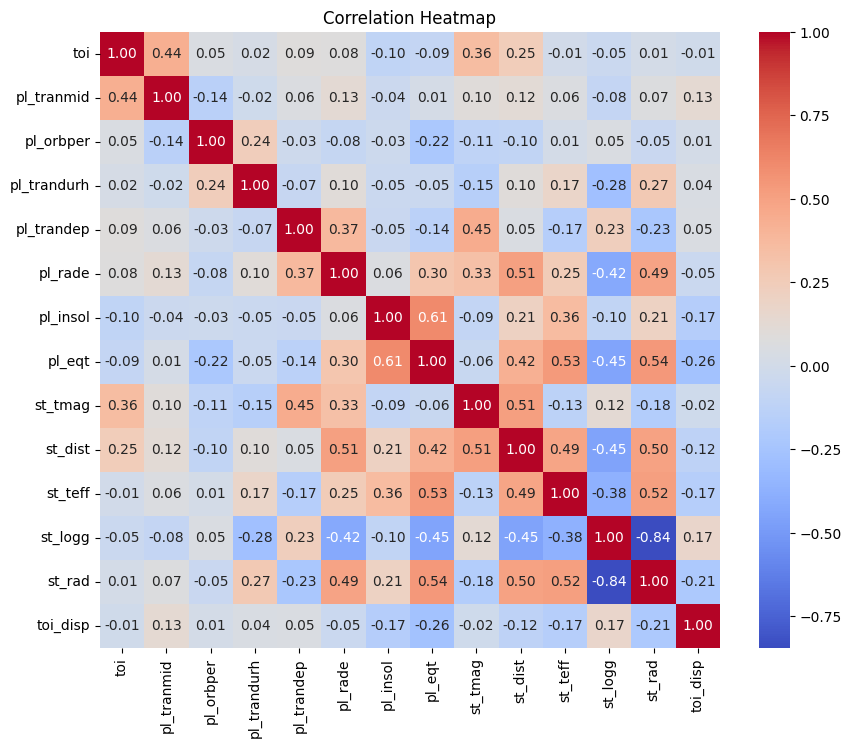

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")